# Multi-Class Prediction

## Import the Libraries

In [1]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import  os

## Gathering Data

*Combine and Load the train data table*

In [2]:
TRAIN_DT = pd.concat( 
    map(pd.read_csv, ['csv/bmi_train.csv', 'csv/bmi.csv']), ignore_index=True) 
TRAIN_DT.head()

,Gender,Height,Weight,Index
0,Male,161,89,4
1,Male,179,127,4
2,Male,172,139,5
3,Male,153,104,5
4,Male,165,68,2


*Load the validation data table*

In [3]:
VALIDATION_DT = pd.read_csv('csv/bmi_validation.csv')
VALIDATION_DT.head()

,Gender,Height,Weight
0,Male,161,103
1,Male,180,75
2,Male,174,95
3,Female,179,103
4,Female,192,140


## Assessing Data

In [4]:
TRAIN_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  900 non-null    object
 1   Height  900 non-null    int64 
 2   Weight  900 non-null    int64 
 3   Index   900 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 28.3+ KB


In [5]:
VALIDATION_DT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  100 non-null    object
 1   Height  100 non-null    int64 
 2   Weight  100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


*Looking for empty or null data/cell in dataset*

In [6]:
TRAIN_DT.isna().sum()

Gender    0
Height    0
Weight    0
Index     0
dtype: int64

In [7]:
VALIDATION_DT.isna().sum()

Gender    0
Height    0
Weight    0
dtype: int64

*Looking for duplicated data in dataset*

In [8]:
TRAIN_DT.duplicated().sum()

411

In [9]:
VALIDATION_DT.duplicated().sum()

0

## Preprocessing and Cleaning the Data

*Making copy of datasets and drop all the duplicates data in train dataset*

In [10]:
train_dt_c = TRAIN_DT.copy()
train_dt_c.drop_duplicates(inplace=True)

valid_dt_c = VALIDATION_DT.copy()

In [11]:
train_dt_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 489 entries, 0 to 897
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Gender  489 non-null    object
 1   Height  489 non-null    int64 
 2   Weight  489 non-null    int64 
 3   Index   489 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.1+ KB


*Using map function to encoding the gender feature with numerical type, 0 for male and 1 for female*

In [12]:
train_dt_c['Gender'] = train_dt_c['Gender'].map({'Male': 0, 'Female': 1})
valid_dt_c['Gender'] = valid_dt_c['Gender'].map({'Male': 0, 'Female': 1})

*Separate the features and label for train dataset*

In [13]:
X = train_dt_c.drop('Index', axis=1)
Y = train_dt_c['Index']

In [14]:
X['BMI'] = X['Weight'] / ( (X['Height'] ** 2)/10000 )
X['BMI'] = X['BMI'].round(2)

In [15]:
X.head()

,Gender,Height,Weight,BMI
0,0,161,89,34.34
1,0,179,127,39.64
2,0,172,139,46.98
3,0,153,104,44.43
4,0,165,68,24.98


*Split the data into 70% Train, 15% Valid and 15% Test*

In [16]:
# Split the dataset into training and temp (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Split the temp dataset into validation and test sets
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

*Augmented the data*

In [17]:
x_train_augmented, y_train_augmented = resample(
    x_train, y_train, 
    n_samples=len(x_train),
    replace=True
)

In [18]:
# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Store the results for each fold
fold_accuracies = []

for train_index, val_index in kf.split(x_train_augmented):
    # Split the data into training and validation sets for this fold using .iloc
    x_train_fold, x_val_fold = x_train_augmented.iloc[train_index], x_train_augmented.iloc[val_index]
    y_train_fold, y_val_fold = y_train_augmented.iloc[train_index], y_train_augmented.iloc[val_index]

In [19]:
x_train.head()

,Gender,Height,Weight,BMI
433,1,160,131,51.17
3,0,153,104,44.43
348,1,155,115,47.87
717,0,142,135,66.95
60,1,150,70,31.11


In [20]:
y_train.head()

433    5
3      5
348    5
717    5
60     4
Name: Index, dtype: int64

## Exploring the data

In [21]:
x_train.describe(include="all")

,Gender,Height,Weight,BMI
count,342.000000,342.000000,342.000000,342.000000
mean,0.523392,170.254386,106.652047,37.781257
std,0.500184,15.989996,31.676221,13.479006
min,0.000000,140.000000,50.000000,12.750000
25%,0.000000,157.000000,81.000000,27.412500
50%,1.000000,171.000000,107.000000,36.970000
75%,1.000000,184.000000,135.750000,45.725000
max,1.000000,199.000000,160.000000,74.490000


In [22]:
y_train.describe(include="all")

count    342.000000
mean       3.774854
std        1.317226
min        0.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Index, dtype: float64

In [23]:
valid_dt_c.describe(include="all")

,Gender,Height,Weight
count,100.00,100.000000,100.000000
mean,0.55,168.270000,105.760000
std,0.50,15.521803,32.626172
min,0.00,141.000000,51.000000
25%,0.00,156.000000,76.500000
50%,1.00,168.000000,103.500000
75%,1.00,180.250000,135.250000
max,1.00,197.000000,160.000000


In [24]:
print ('The shape of X_train is: ' + str(x_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

print ('\nThe shape of validation dataset is: ' + str(valid_dt_c.shape))
print ('We have m = %d validation examples' % (len(valid_dt_c)))

The shape of X_train is: (342, 4)
The shape of y_train is: (342,)
We have m = 342 training examples

The shape of validation dataset is: (100, 3)
We have m = 100 validation examples


## Visualize the Data

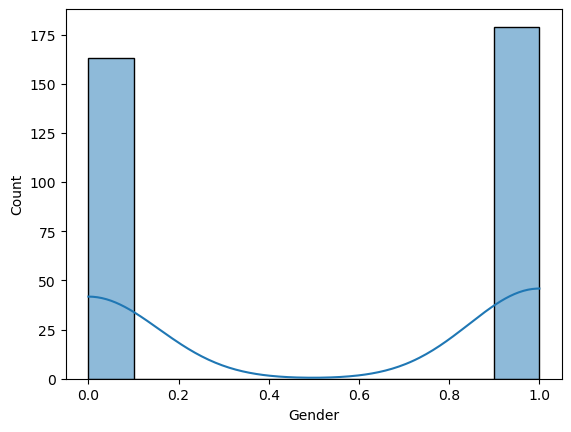

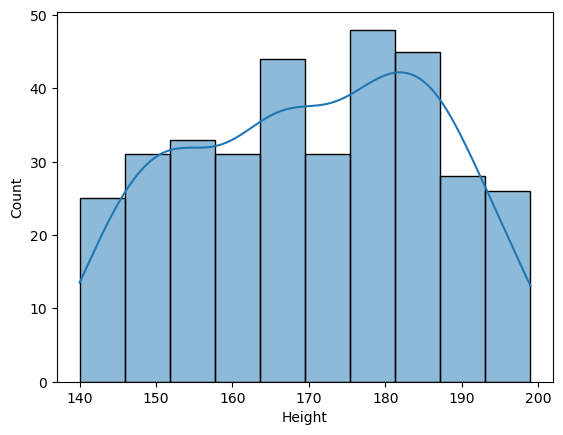

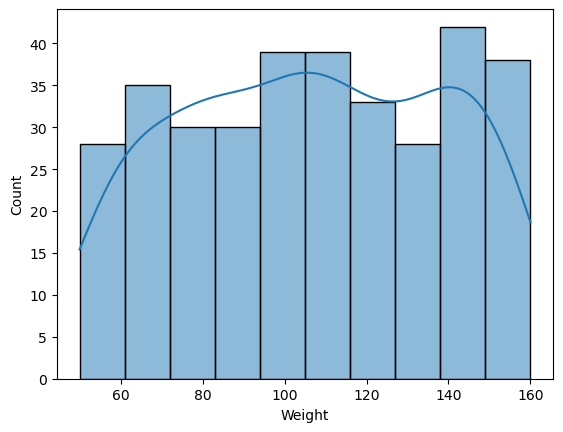

In [25]:
data = x_train['Gender']

# Histogram
sns.histplot(data, kde=True)
plt.show()

data = x_train['Height']

# Histogram
sns.histplot(data, kde=True)
plt.show()

data = x_train['Weight']

# Histogram
sns.histplot(data, kde=True)
plt.show()

## Training the Data

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(4,)),

    tf.keras.layers.Dense(90, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    
    tf.keras.layers.Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ]) 
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [27]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 4)
Output shape: (None, 6)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 90)             │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         5,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,552 (33.41 KB)

 Trainable params: 8,552 (33.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ModelCheckpoint callback is used in conjunction with training using model.fit() 
# to save a model or weights (in a checkpoint file) at some interval, so the model 
# or weights can be loaded later to continue the training from the state saved.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best model weights
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

history = model.fit(
    x_train_augmented, y_train_augmented,
    validation_data=(x_valid, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)

# model.save('bmi_augmented_model_2.keras')

Epoch 1/50
11/11 - 2s - 179ms/step - accuracy: 0.1404 - loss: 13.3427 - val_accuracy: 0.2740 - val_loss: 7.4865 - learning_rate: 5.0000e-04
Epoch 2/50
11/11 - 0s - 10ms/step - accuracy: 0.3538 - loss: 5.4679 - val_accuracy: 0.2192 - val_loss: 3.2224 - learning_rate: 5.0000e-04
Epoch 3/50
11/11 - 0s - 10ms/step - accuracy: 0.4035 - loss: 1.8032 - val_accuracy: 0.5068 - val_loss: 1.4413 - learning_rate: 5.0000e-04
Epoch 4/50
11/11 - 0s - 11ms/step - accuracy: 0.4211 - loss: 1.3323 - val_accuracy: 0.5479 - val_loss: 1.0538 - learning_rate: 5.0000e-04
Epoch 5/50
11/11 - 0s - 12ms/step - accuracy: 0.6023 - loss: 0.9603 - val_accuracy: 0.6301 - val_loss: 0.8883 - learning_rate: 5.0000e-04
Epoch 6/50
11/11 - 0s - 8ms/step - accuracy: 0.6345 - loss: 0.8116 - val_accuracy: 0.7123 - val_loss: 0.7122 - learning_rate: 5.0000e-04
Epoch 7/50
11/11 - 0s - 9ms/step - accuracy: 0.6550 - loss: 0.7335 - val_accuracy: 0.7534 - val_loss: 0.7023 - learning_rate: 5.0000e-04
Epoch 8/50
11/11 - 0s - 19ms/step 

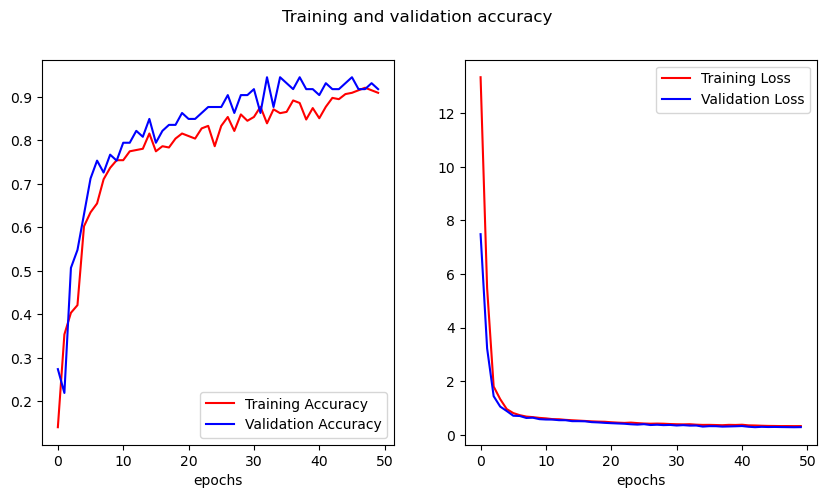

In [30]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

*Using the best model that have been saved using checkpoint callback*

In [31]:
# model = tf.keras.models.load_model("saved_modelsBMI/weights-improvment-35-0.44.keras")

In [32]:
# Predict the model
y_pred = model.predict(x_test)

y_pred_class = np.argmax(y_pred, axis=1)

accuracy = np.mean(y_test == y_pred_class)

# Print out the accuracy that based on comparing the y_test and the predicted labels
print(f'Accuracy: {accuracy*100:.2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 90.54%


In [33]:
# gender = int(input("Masukkan gender anda dalam 0 untuk pria / 1 untuk wanita: "))
# height = int(input("Masukkan tinggi badan anda: "))
# weight = int(input("Masukkan tinggi badan anda: "))

gender = 0
height = 175
weight = 65

bmi = np.round(weight/(height**2/10000), 2)

test_feature = np.array([
    [gender, height, weight, bmi]
])

In [34]:
# Predict the model
test_label_pred = model.predict(test_feature)
test_label_pred_class = np.argmax(test_label_pred)
print(f'Gender = {gender}\nHeight = {height}\nWeight = {weight}\nBMI = {bmi}\nPredict = {test_label_pred_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Gender = 0
Height = 175
Weight = 65
BMI = 21.22
Predict = 2


In [35]:
# model.save('bmi_model-accuracy_0.90-loss_0.26-val_accuracy_0.91-val_loss_0.23.keras')